### Notebook
- Creates Figure S6: Sex- and age-specific MHC presentation of common driver mutations not relying on PHBR scores. 
- Uses NetMHCpan affinities only.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu
import sys
sys.path.append('/cellar/users/andreabc/scripts/')
from benjamini_fdr import benjamini_fdr

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('white')
sns.set_style("ticks")

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

### Load NetMHCpan data

In [3]:
# Load NetMHCpan affinities for driver mutations across all alleles
driver_aff_I = pd.read_csv('../data/mhc_i.driver.matrix', 
                           sep='\t', index_col=0)
driver_aff_II = pd.read_csv('../data/mhc_ii.driver.matrix', 
                           sep='\t', index_col=0)

In [4]:
driver_aff_I_median = pd.DataFrame(driver_aff_I.median(axis=1), columns=['median_rank'])
driver_aff_II_median = pd.DataFrame(driver_aff_II.median(axis=1), columns=['median_rank'])

### Load TCGA clinical, expressed mutation data

In [5]:
clinical_df = pd.read_csv('../data/all_clinical_tcga.txt.gz',sep='\t',
                          index_col='bcr_patient_barcode')[['gender','age_at_initial_pathologic_diagnosis']]

# add age categorical 
young_thresh = 52  # 30th percentile: 52
old_thresh = 68-1   # 70th percentile: 68

clinical_df['age_at_initial_pathologic_diagnosis'] = pd.to_numeric(clinical_df['age_at_initial_pathologic_diagnosis'], errors='coerce')
clinical_df['age_categorical_3070'] = pd.cut(clinical_df['age_at_initial_pathologic_diagnosis'], 
                                             [0, young_thresh, old_thresh, clinical_df['age_at_initial_pathologic_diagnosis'].max()], 
                                             labels=['younger', 'middle', 'older'])
clinical_df['category'] = clinical_df.apply(lambda x: '{}\n{}'.format(x.age_categorical_3070, x.gender.lower()), axis=1)

clinical_df.head(2)

,gender,age_at_initial_pathologic_diagnosis,age_categorical_3070,category
bcr_patient_barcode,,,,
TCGA-3C-AAAU,FEMALE,55.0,middle,middle\nfemale
TCGA-3C-AALI,FEMALE,50.0,younger,younger\nfemale


In [6]:
mut_df = pd.read_csv('../data/expressed_driver_mutations.csv',
                     index_col=0)
print(mut_df.shape)
mut_df = mut_df.join(clinical_df, how='left')
mut_df.head(2)

(8557, 1)


,exp_mutations,gender,age_at_initial_pathologic_diagnosis,age_categorical_3070,category
TCGA-02-0047,M_BRAF_V600E,MALE,78.0,older,older\nmale
TCGA-02-0047,M_PIK3CA_N345K,MALE,78.0,older,older\nmale


In [7]:
def get_joint_pvals(df, column):
    data = df.copy()
    f_data = data[data['gender']=='FEMALE']
    m_data = data[data['gender']=='MALE']

    YF_OF = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         f_data[f_data['age_categorical_3070'] == 'older'][column].values).pvalue
    YF_OM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue
    YF_YM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'younger'][column].values).pvalue

    OF_YM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'older'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'younger'][column].values).pvalue
    OF_OM = mannwhitneyu(f_data[f_data['age_categorical_3070'] == 'older'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue

    YM_OM = mannwhitneyu(m_data[m_data['age_categorical_3070'] == 'younger'][column].values, 
                         m_data[m_data['age_categorical_3070'] == 'older'][column].values).pvalue

    pvals = [['Young female, Old female', YF_OF], ['Young female, Old male', YF_OM], 
             ['Young female, Young male', YF_YM], ['Old female, Young male', OF_YM], 
             ['Old female, Old male', OF_OM], ['Young male, Old male', YM_OM]]
    return benjamini_fdr(pvals)

### Plot RNA fraction
 

In [8]:
def add_median_labels(median_list, ax, height_above_median=0.5):
    for pos, tick, median in zip(range(2), ax.get_xticklabels(), median_list):
        ax.text(pos, median + height_above_median, round(median, 2), 
                horizontalalignment='center', size='x-small', color='w', weight='semibold')

##### MHC-I


Sex medians: gender
FEMALE    3.68555
MALE      3.41610
Name: median_rank, dtype: float64

Age medians: age_categorical_3070
younger    3.5360
middle     3.6315
older      3.6160
Name: median_rank, dtype: float64

Combined P-values:  [['Young female, Young male', 0.01618214271998781], ['Young female, Old male', 0.018946046437979758], ['Young female, Old female', 0.04319412333747917], ['Old female, Young male', 0.2736462549529465], ['Old female, Old male', 0.32913079819298724], ['Young male, Old male', 0.4201478830045495]]

Combined medians: category
middle\nfemale     3.72410
middle\nmale       3.41610
nan\nfemale        3.91275
nan\nmale          3.41610
older\nfemale      3.67490
older\nmale        3.48710
younger\nfemale    3.72410
younger\nmale      3.08320
Name: median_rank, dtype: float64


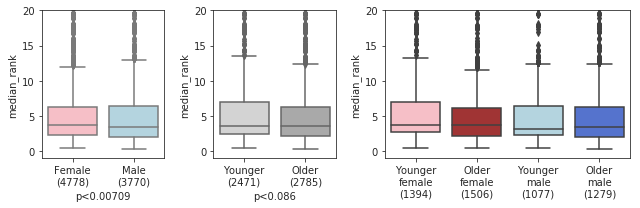

In [12]:
data = pd.merge(mut_df, driver_aff_I_median.reset_index(), left_on='exp_mutations', right_on='index', how='left')

fig = plt.figure(figsize=(9,3)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5,2.5,5]) 

## Sex
ax0 = plt.subplot(gs[0])
p = mannwhitneyu(data[data['gender']=='FEMALE']['median_rank'].values,
                 data[data['gender']=='MALE']['median_rank'].values).pvalue

sns.boxplot(x='gender', y='median_rank', data=data, order=['FEMALE','MALE'],
            palette=['lightpink', 'lightblue'], ax=ax0)
plt.xlabel('p<{:.3}'.format(p)), 
# plt.xticks([0,1],['female','male']), 

plt.xticks([0,1], ['Female\n({})'.format(len(set(data[data['gender']=='FEMALE'].index))), 
                   'Male\n({})'.format(len(set(data[data['gender']=='MALE'].index)))])
plt.ylim(-1,20)
medians = data.groupby(['gender'])['median_rank'].median()
print('\nSex medians:', medians)



## Age
ax1 = plt.subplot(gs[1])
p = mannwhitneyu(data[data['age_categorical_3070']=='younger']['median_rank'].values,
                 data[data['age_categorical_3070']=='older']['median_rank'].values).pvalue

sns.boxplot(x='age_categorical_3070', y='median_rank', data=data, order=['younger','older'],
            palette=['lightgrey', 'darkgrey'], ax=ax1)
plt.xlabel('p<{:.3}'.format(p)), 
plt.xticks([0,1], ['Younger\n({})'.format(len(set(data[data['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(data[data['age_categorical_3070']=='older'].index)))])
plt.ylim(-1,20)
medians = data.groupby(['age_categorical_3070'])['median_rank'].median()
print('\nAge medians:', medians)



## Both
ax2 = plt.subplot(gs[2])
print('\nCombined P-values: ',get_joint_pvals(data, 'median_rank'))

sns.boxplot(x='category', y='median_rank', data=data, palette=['lightpink','firebrick','lightblue','royalblue'], 
            order=['younger\nfemale','older\nfemale','younger\nmale','older\nmale'], ax=ax2)
plt.ylim(-1,20), plt.xlabel('')
plt.xticks([0,1,2,3],['Younger\nfemale\n({})'.format(len(data[data['category']=='younger\nfemale'])), 
                      'Older\nfemale\n({})'.format(len(data[data['category']=='older\nfemale'])), 
                      'Younger\nmale\n({})'.format(len(data[data['category']=='younger\nmale'])), 
                      'Older\nmale\n({})'.format(len(data[data['category']=='older\nmale']))])

plt.tight_layout()

medians = data.groupby(['category'])['median_rank'].median()
print('\nCombined medians:', medians)

savepath = '../figures/S6_I_netmhcpan_median_rank.boxplot.pdf'
plt.savefig(savepath)
plt.show()

##### MHC-II


Sex medians: gender
FEMALE    31.0
MALE      26.0
Name: median_rank, dtype: float64

Age medians: age_categorical_3070
younger    30.0
middle     28.0
older      28.0
Name: median_rank, dtype: float64

Combined P-values:  [['Young female, Old male', 4.645676615201199e-05], ['Young female, Young male', 0.00048648601270274256], ['Young female, Old female', 0.0007681502921429626], ['Young male, Old male', 0.23738098237441393], ['Old female, Old male', 0.2071079517450426], ['Old female, Young male', 0.42917286522252174]]

Combined medians: category
middle\nfemale     30.0
middle\nmale       27.0
nan\nfemale        28.5
nan\nmale          28.0
older\nfemale      31.0
older\nmale        26.0
younger\nfemale    32.0
younger\nmale      26.0
Name: median_rank, dtype: float64


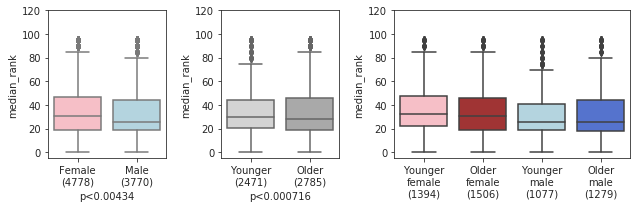

In [14]:
data = pd.merge(mut_df, driver_aff_II_median.reset_index(), left_on='exp_mutations', right_on='index', how='left')

fig = plt.figure(figsize=(9,3)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5,2.5,5]) 

## Sex
ax0 = plt.subplot(gs[0])
p = mannwhitneyu(data[data['gender']=='FEMALE']['median_rank'].values,
                 data[data['gender']=='MALE']['median_rank'].values).pvalue

sns.boxplot(x='gender', y='median_rank', data=data, order=['FEMALE','MALE'],
            palette=['lightpink', 'lightblue'], ax=ax0)
plt.xlabel('p<{:.3}'.format(p))

plt.xticks([0,1], ['Female\n({})'.format(len(set(data[data['gender']=='FEMALE'].index))), 
                   'Male\n({})'.format(len(set(data[data['gender']=='MALE'].index)))])
plt.ylim(-5,120)
medians = data.groupby(['gender'])['median_rank'].median()
print('\nSex medians:', medians)

## Age
ax1 = plt.subplot(gs[1])
p = mannwhitneyu(data[data['age_categorical_3070']=='younger']['median_rank'].values,
                 data[data['age_categorical_3070']=='older']['median_rank'].values).pvalue

sns.boxplot(x='age_categorical_3070', y='median_rank', data=data, order=['younger','older'],
            palette=['lightgrey', 'darkgrey'], ax=ax1)
plt.xlabel('p<{:.3}'.format(p)),
plt.xticks([0,1], ['Younger\n({})'.format(len(set(data[data['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(data[data['age_categorical_3070']=='older'].index)))])
plt.ylim(-5,120)
medians = data.groupby(['age_categorical_3070'])['median_rank'].median()
print('\nAge medians:', medians)


## Both
ax2 = plt.subplot(gs[2])
print('\nCombined P-values: ',get_joint_pvals(data, 'median_rank'))

sns.boxplot(x='category', y='median_rank', data=data, palette=['lightpink','firebrick','lightblue','royalblue'], 
            order=['younger\nfemale','older\nfemale','younger\nmale','older\nmale'], ax=ax2)
plt.ylim(-5,120)
plt.xlabel('')
plt.xticks([0,1,2,3],['Younger\nfemale\n({})'.format(len(data[data['category']=='younger\nfemale'])), 
                      'Older\nfemale\n({})'.format(len(data[data['category']=='older\nfemale'])), 
                      'Younger\nmale\n({})'.format(len(data[data['category']=='younger\nmale'])), 
                      'Older\nmale\n({})'.format(len(data[data['category']=='older\nmale']))])
plt.tight_layout()

medians = data.groupby(['category'])['median_rank'].median()
print('\nCombined medians:', medians)

## Save
savepath = '../figures/S6_II_netmhcpan_median_rank.boxplot.pdf'
plt.savefig(savepath)
plt.show()